In [20]:
nasdaq100_tickers = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMD", "AMAT", "AMGN",
    "AMZN", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR",
    "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO",
    "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG",
    "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDLZ", "MELI", "META", "MNST", "PEP", "PLTR", "PYPL", "QCOM", "REGN", "ROP",
    "ROST", "SBUX", "SHOP", "SNPS", "TEAM", "TMUS", "TSLA", "TTD", "TTWO", "TXN",
    "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"
]

# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import run_full_analysis

In [18]:
# Advanced Metrics Functions

def calculate_max_drawdown(equity_curve):
    """Calculate maximum drawdown from equity curve"""
    cummax = equity_curve.cummax()
    drawdown = (equity_curve - cummax) / cummax * 100
    return drawdown.min()


def calculate_cagr(initial_value, final_value, num_years):
    """Calculate Compound Annual Growth Rate"""
    if num_years == 0 or initial_value <= 0:
        return 0
    return (((final_value / initial_value) ** (1 / num_years)) - 1) * 100


def calculate_sharpe_ratio(returns, periods_per_year=252):
    """Calculate annualized Sharpe ratio (assuming risk-free rate = 0)"""
    if len(returns) == 0 or returns.std() == 0:
        return 0
    return (returns.mean() / returns.std()) * np.sqrt(periods_per_year)


def calculate_profit_factor(df):
    """Calculate profit factor from trades"""
    position_changes = df["Position"].diff()
    entries = df[position_changes == 1].index
    exits = df[position_changes == -1].index
    
    if len(entries) == 0 or len(exits) == 0:
        return 0
    
    # Calculate trade-level returns
    trade_returns = []
    for i in range(min(len(entries), len(exits))):
        entry_idx = entries[i]
        exit_idx = exits[i]
        
        if exit_idx > entry_idx:
            entry_value = df.loc[entry_idx, "Strategy_Portfolio_Value"]
            exit_value = df.loc[exit_idx, "Strategy_Portfolio_Value"]
            trade_return = exit_value - entry_value
            trade_returns.append(trade_return)
    
    if len(trade_returns) == 0:
        return 0
    
    profits = sum([r for r in trade_returns if r > 0])
    losses = abs(sum([r for r in trade_returns if r < 0]))
    
    if losses == 0:
        return profits if profits > 0 else 0
    
    return profits / losses


def calculate_advanced_metrics(df):
    """Calculate all advanced metrics for a strategy"""
    metrics = {}
    
    # Final values
    initial_investment = df["Strategy_Portfolio_Value"].iloc[0] if len(df) > 0 else 10000
    metrics['strategy_final'] = df["Strategy_Portfolio_Value"].iloc[-1]
    metrics['simple_final'] = df["Simple_Portfolio_Value"].iloc[-1]
    
    # Total returns
    metrics['strategy_return_pct'] = ((metrics['strategy_final'] - initial_investment) / initial_investment) * 100
    metrics['simple_return_pct'] = ((metrics['simple_final'] - initial_investment) / initial_investment) * 100
    
    # Calculate number of years
    num_years = (df.index[-1] - df.index[0]).days / 365.25
    metrics['num_years'] = num_years
    
    # 1. CAGR
    metrics['strategy_cagr'] = calculate_cagr(initial_investment, metrics['strategy_final'], num_years)
    metrics['simple_cagr'] = calculate_cagr(initial_investment, metrics['simple_final'], num_years)
    
    # 2. Maximum Drawdown
    metrics['strategy_max_drawdown'] = calculate_max_drawdown(df["Strategy_Portfolio_Value"])
    metrics['simple_max_drawdown'] = calculate_max_drawdown(df["Simple_Portfolio_Value"])
    
    # 3. Sharpe Ratio
    metrics['strategy_sharpe'] = calculate_sharpe_ratio(df["Strategy_Return"])
    metrics['simple_sharpe'] = calculate_sharpe_ratio(df["Daily_Return"])
    
    # 4. Win Rate (percentage of days with positive strategy returns when in position)
    in_position = df[df["Position"] == 1]
    if len(in_position) > 0:
        winning_days = len(in_position[in_position["Strategy_Return"] > 0])
        metrics['win_rate'] = (winning_days / len(in_position)) * 100
    else:
        metrics['win_rate'] = 0
    
    # 5. Profit Factor
    metrics['profit_factor'] = calculate_profit_factor(df)
    
    # Number of trades (complete entry-exit pairs)
    position_changes = df["Position"].diff()
    entries = (position_changes == 1).sum()
    exits = (position_changes == -1).sum()
    metrics['num_trades'] = min(entries, exits)
    
    return metrics

## Cohen Parameters Analysis

Analyzing Cohen's recommended parameters:
- **Degree**: 4
- **Window**: 60 days
- **Bandwidth**: 2.0

This section calculates all advanced metrics across the NASDAQ-100 universe.

In [ ]:
# Run analysis with Cohen's parameters
cohen_degree = 4
cohen_window = 60
cohen_bandwidth = 2.0

data_dir = "nasdaq100_data"
all_results = []

print(f"Running analysis with Cohen's parameters:")
print(f"  Degree: {cohen_degree}")
print(f"  Window: {cohen_window}")
print(f"  Bandwidth: {cohen_bandwidth}")
print(f"\nProcessing {len(nasdaq100_tickers)} stocks...")

for ticker in nasdaq100_tickers:
    try:
        # Load stock data
        csv_path = os.path.join(data_dir, f"{ticker}.csv")
        if not os.path.exists(csv_path):
            print(f"Skipping {ticker}: file not found")
            continue
        
        df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
        
        # Run analysis
        df_analyzed = run_full_analysis(df, degree=cohen_degree, window=cohen_window, k=cohen_bandwidth)
        
        # Calculate advanced metrics
        metrics = calculate_advanced_metrics(df_analyzed)
        metrics['ticker'] = ticker
        
        all_results.append(metrics)
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# Convert to DataFrame
cohen_results = pd.DataFrame(all_results)

print(f"\nPreview of results:")
print(cohen_results[['ticker', 'strategy_cagr', 'strategy_sharpe', 'strategy_max_drawdown', 'profit_factor', 'win_rate']].head())

Running analysis with Cohen's parameters:
  Degree: 4
  Window: 60
  Bandwidth: 2.0

Processing 86 stocks...

✓ Successfully analyzed 86 stocks

Preview of results:
  ticker  strategy_cagr  strategy_sharpe  strategy_max_drawdown  \
0   AAPL      17.105591         0.867409             -31.500173   
1   ABNB     -14.557531        -0.307199             -66.042193   
2   ADBE      15.888873         0.769769             -38.669766   
3    ADI      12.923515         0.700610             -27.478574   
4    ADP       7.902727         0.559800             -32.981568   
5   ADSK      11.341166         0.539016             -51.955518   
6    AEP      12.172765         0.895747             -16.099626   
7    AMD      13.441041         0.524952             -59.827991   
8   AMAT      16.018253         0.696510             -43.255475   
9   AMGN      12.418993         0.782216             -22.131060   

   profit_factor   win_rate  
0       2.586596  53.907496  
1       0.513645  48.326360  
2      

In [21]:

print(f"\nStrategy CAGR:")
print(f"  Mean:   {cohen_results['strategy_cagr'].mean():>8.2f}%")
print(f"  Median: {cohen_results['strategy_cagr'].median():>8.2f}%")
print(f"  Std:    {cohen_results['strategy_cagr'].std():>8.2f}%")
print(f"  Min:    {cohen_results['strategy_cagr'].min():>8.2f}%")
print(f"  Max:    {cohen_results['strategy_cagr'].max():>8.2f}%")

print(f"\nBuy-and-Hold CAGR:")
print(f"  Mean:   {cohen_results['simple_cagr'].mean():>8.2f}%")
print(f"  Median: {cohen_results['simple_cagr'].median():>8.2f}%")
print(f"  Std:    {cohen_results['simple_cagr'].std():>8.2f}%")
print(f"  Min:    {cohen_results['simple_cagr'].min():>8.2f}%")
print(f"  Max:    {cohen_results['simple_cagr'].max():>8.2f}%")

print(f"\nStrategy vs Buy-and-Hold:")
outperform_count = (cohen_results['strategy_cagr'] > cohen_results['simple_cagr']).sum()
print(f"  Stocks where strategy outperforms: {outperform_count}/{len(cohen_results)} ({100*outperform_count/len(cohen_results):.1f}%)")
print(f"  Average CAGR difference: {(cohen_results['strategy_cagr'] - cohen_results['simple_cagr']).mean():.2f}%")

print(f"\nTop 5 Strategy CAGR performers:")
top_5_cagr = cohen_results.nlargest(5, 'strategy_cagr')[['ticker', 'strategy_cagr', 'simple_cagr']]
print(top_5_cagr.to_string(index=False))


Strategy CAGR:
  Mean:      12.06%
  Median:    10.98%
  Std:       11.73%
  Min:      -14.56%
  Max:       97.64%

Buy-and-Hold CAGR:
  Mean:      21.58%
  Median:    19.51%
  Std:       17.44%
  Min:       -6.33%
  Max:      119.55%

Strategy vs Buy-and-Hold:
  Stocks where strategy outperforms: 11/86 (12.8%)
  Average CAGR difference: -9.53%

Top 5 Strategy CAGR performers:
ticker  strategy_cagr  simple_cagr
   ARM      97.637543   119.554751
  META      27.970871    24.639404
  AVGO      27.903844    38.990327
   TTD      27.769763    57.876798
   CEG      27.017766    95.164121


In [22]:
# max drawdown analysis

print(f"\nStrategy Max Drawdown:")
print(f"  Mean:   {cohen_results['strategy_max_drawdown'].mean():>8.2f}%")
print(f"  Median: {cohen_results['strategy_max_drawdown'].median():>8.2f}%")
print(f"  Worst:  {cohen_results['strategy_max_drawdown'].min():>8.2f}%")
print(f"  Best:   {cohen_results['strategy_max_drawdown'].max():>8.2f}%")

print(f"\nBuy-and-Hold Max Drawdown:")
print(f"  Mean:   {cohen_results['simple_max_drawdown'].mean():>8.2f}%")
print(f"  Median: {cohen_results['simple_max_drawdown'].median():>8.2f}%")
print(f"  Worst:  {cohen_results['simple_max_drawdown'].min():>8.2f}%")
print(f"  Best:   {cohen_results['simple_max_drawdown'].max():>8.2f}%")

print(f"\nRisk Reduction:")
lower_dd_count = (cohen_results['strategy_max_drawdown'] > cohen_results['simple_max_drawdown']).sum()
print(f"  Stocks with lower drawdown (strategy): {lower_dd_count}/{len(cohen_results)} ({100*lower_dd_count/len(cohen_results):.1f}%)")
print(f"  Average drawdown reduction: {(cohen_results['strategy_max_drawdown'] - cohen_results['simple_max_drawdown']).mean():.2f}%")

print(f"\nTop 5 stocks with best (lowest) strategy drawdown:")
top_5_dd = cohen_results.nlargest(5, 'strategy_max_drawdown')[['ticker', 'strategy_max_drawdown', 'simple_max_drawdown']]
print(top_5_dd.to_string(index=False))


Strategy Max Drawdown:
  Mean:     -43.88%
  Median:   -38.96%
  Worst:    -84.90%
  Best:     -14.53%

Buy-and-Hold Max Drawdown:
  Mean:     -53.08%
  Median:   -50.55%
  Worst:    -91.90%
  Best:     -24.86%

Risk Reduction:
  Stocks with lower drawdown (strategy): 73/86 (84.9%)
  Average drawdown reduction: 9.21%

Top 5 stocks with best (lowest) strategy drawdown:
ticker  strategy_max_drawdown  simple_max_drawdown
   PEP             -14.525447           -28.817072
   AEP             -16.099626           -32.905208
   LIN             -18.736008           -32.585056
  MDLZ             -20.073578           -29.741949
  COST             -20.325341           -31.402443


In [ ]:
# sharpe ratio analysis

print(f"\nStrategy Sharpe Ratio:")
print(f"  Mean:   {cohen_results['strategy_sharpe'].mean():>8.2f}")
print(f"  Median: {cohen_results['strategy_sharpe'].median():>8.2f}")
print(f"  Std:    {cohen_results['strategy_sharpe'].std():>8.2f}")
print(f"  Min:    {cohen_results['strategy_sharpe'].min():>8.2f}")
print(f"  Max:    {cohen_results['strategy_sharpe'].max():>8.2f}")

print(f"\nBuy-and-Hold Sharpe Ratio:")
print(f"  Mean:   {cohen_results['simple_sharpe'].mean():>8.2f}")
print(f"  Median: {cohen_results['simple_sharpe'].median():>8.2f}")
print(f"  Std:    {cohen_results['simple_sharpe'].std():>8.2f}")
print(f"  Min:    {cohen_results['simple_sharpe'].min():>8.2f}")
print(f"  Max:    {cohen_results['simple_sharpe'].max():>8.2f}")

print(f"\nRisk-Adjusted Performance:")
better_sharpe_count = (cohen_results['strategy_sharpe'] > cohen_results['simple_sharpe']).sum()
print(f"  Stocks with better Sharpe (strategy): {better_sharpe_count}/{len(cohen_results)} ({100*better_sharpe_count/len(cohen_results):.1f}%)")
print(f"  Average Sharpe difference: {(cohen_results['strategy_sharpe'] - cohen_results['simple_sharpe']).mean():.2f}")

print(f"\nTop 5 Strategy Sharpe performers:")
top_5_sharpe = cohen_results.nlargest(5, 'strategy_sharpe')[['ticker', 'strategy_sharpe', 'simple_sharpe']]
print(top_5_sharpe.to_string(index=False))

3. SHARPE RATIO (Risk-Adjusted Returns)

Strategy Sharpe Ratio:
  Mean:       0.58
  Median:     0.60
  Std:        0.28
  Min:       -0.31
  Max:        1.78

Buy-and-Hold Sharpe Ratio:
  Mean:       0.71
  Median:     0.73
  Std:        0.26
  Min:       -0.01
  Max:        1.76

Risk-Adjusted Performance:
  Stocks with better Sharpe (strategy): 26/86 (30.2%)
  Average Sharpe difference: -0.13

Top 5 Strategy Sharpe performers:
ticker  strategy_sharpe  simple_sharpe
   ARM         1.778687       1.317612
  COST         1.097959       1.113737
  AVGO         1.084123       1.094800
   CEG         1.002548       1.757787
  META         0.993412       0.751740



Win Rate Statistics:
  Mean:      52.62%
  Median:    52.62%
  Std:        1.77%
  Min:       48.33%
  Max:       60.66%

Win Rate Distribution:
  Stocks with win rate >= 50%: 81/86 (94.2%)
  Stocks with win rate >= 60%: 1/86 (1.2%)

Top 5 Win Rate performers:
ticker  win_rate  num_trades
   ARM 60.655738           8
  CTAS 56.731757         112
   CEG 56.293706          18
  AVGO 55.185384         112
   AEP 55.106499         114


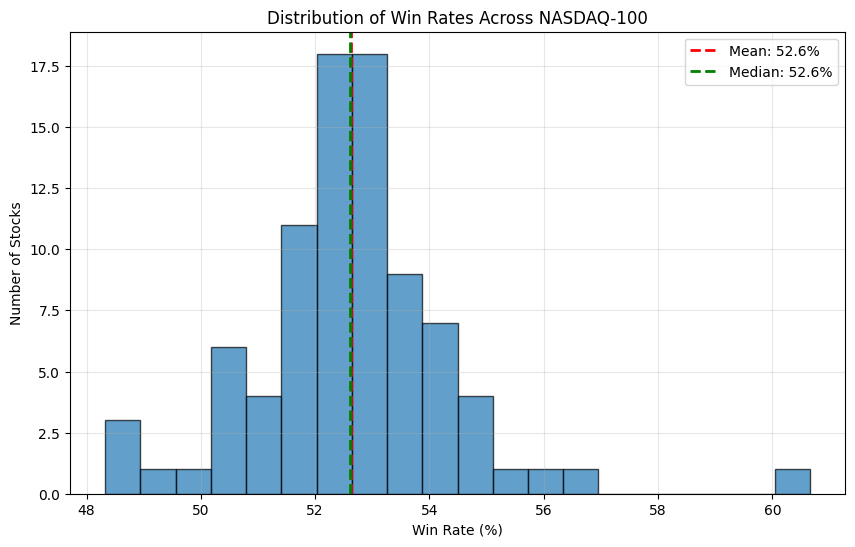

In [24]:
# win rate analysis

print(f"\nWin Rate Statistics:")
print(f"  Mean:   {cohen_results['win_rate'].mean():>8.2f}%")
print(f"  Median: {cohen_results['win_rate'].median():>8.2f}%")
print(f"  Std:    {cohen_results['win_rate'].std():>8.2f}%")
print(f"  Min:    {cohen_results['win_rate'].min():>8.2f}%")
print(f"  Max:    {cohen_results['win_rate'].max():>8.2f}%")

print(f"\nWin Rate Distribution:")
high_win_rate = (cohen_results['win_rate'] >= 50).sum()
print(f"  Stocks with win rate >= 50%: {high_win_rate}/{len(cohen_results)} ({100*high_win_rate/len(cohen_results):.1f}%)")
very_high_win_rate = (cohen_results['win_rate'] >= 60).sum()
print(f"  Stocks with win rate >= 60%: {very_high_win_rate}/{len(cohen_results)} ({100*very_high_win_rate/len(cohen_results):.1f}%)")

print(f"\nTop 5 Win Rate performers:")
top_5_wr = cohen_results.nlargest(5, 'win_rate')[['ticker', 'win_rate', 'num_trades']]
print(top_5_wr.to_string(index=False))

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(cohen_results['win_rate'], bins=20, edgecolor='black', alpha=0.7)
plt.axvline(cohen_results['win_rate'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cohen_results["win_rate"].mean():.1f}%')
plt.axvline(cohen_results['win_rate'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {cohen_results["win_rate"].median():.1f}%')
plt.xlabel('Win Rate (%)')
plt.ylabel('Number of Stocks')
plt.title('Distribution of Win Rates Across NASDAQ-100')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# 5. Profit Factor Analysis
print("="*80)
print("5. PROFIT FACTOR (Trade Efficiency)")
print("="*80)

print(f"\nProfit Factor Statistics:")
print(f"  Mean:   {cohen_results['profit_factor'].mean():>8.2f}")
print(f"  Median: {cohen_results['profit_factor'].median():>8.2f}")
print(f"  Std:    {cohen_results['profit_factor'].std():>8.2f}")
print(f"  Min:    {cohen_results['profit_factor'].min():>8.2f}")
print(f"  Max:    {cohen_results['profit_factor'].max():>8.2f}")

print(f"\nProfit Factor Breakdown:")
profitable_count = (cohen_results['profit_factor'] > 1).sum()
print(f"  Stocks with PF > 1 (profitable): {profitable_count}/{len(cohen_results)} ({100*profitable_count/len(cohen_results):.1f}%)")
very_profitable_count = (cohen_results['profit_factor'] > 1.5).sum()
print(f"  Stocks with PF > 1.5 (very profitable): {very_profitable_count}/{len(cohen_results)} ({100*very_profitable_count/len(cohen_results):.1f}%)")

print(f"\nRelationship to CAGR:")
print(f"  Correlation (PF vs CAGR): {cohen_results['profit_factor'].corr(cohen_results['strategy_cagr']):.3f}")

print(f"\nTop 5 Profit Factor performers:")
top_5_pf = cohen_results.nlargest(5, 'profit_factor')[['ticker', 'profit_factor', 'strategy_cagr', 'win_rate']]
print(top_5_pf.to_string(index=False))

5. PROFIT FACTOR (Trade Efficiency)

Profit Factor Statistics:
  Mean:       1.69
  Median:     1.51
  Std:        0.74
  Min:        0.51
  Max:        6.43

Profit Factor Breakdown:
  Stocks with PF > 1 (profitable): 81/86 (94.2%)
  Stocks with PF > 1.5 (very profitable): 44/86 (51.2%)

Relationship to CAGR:
  Correlation (PF vs CAGR): 0.818

Top 5 Profit Factor performers:
ticker  profit_factor  strategy_cagr  win_rate
   ARM       6.428084      97.637543 60.655738
  COST       3.610416      14.986786 53.317394
  AMZN       2.937952      15.836240 52.713178
  FAST       2.817429      14.983810 54.540511
   AEP       2.790100      12.172765 55.106499


In [26]:
# 6. Overall Summary
print("="*80)
print("COHEN PARAMETERS - COMPREHENSIVE SUMMARY")
print("="*80)

print(f"\nPortfolio Overview:")
print(f"  Total stocks analyzed: {len(cohen_results)}")
print(f"  Average time period: {cohen_results['num_years'].mean():.2f} years")
print(f"  Average trades per stock: {cohen_results['num_trades'].mean():.1f}")

print(f"\n{'Metric':<30} {'Strategy':<15} {'Buy & Hold':<15} {'Difference':<15}")
print("-"*75)
print(f"{'CAGR (mean)':<30} {cohen_results['strategy_cagr'].mean():>12.2f}%  {cohen_results['simple_cagr'].mean():>12.2f}%  {(cohen_results['strategy_cagr'] - cohen_results['simple_cagr']).mean():>12.2f}%")
print(f"{'Sharpe Ratio (mean)':<30} {cohen_results['strategy_sharpe'].mean():>14.2f}  {cohen_results['simple_sharpe'].mean():>14.2f}  {(cohen_results['strategy_sharpe'] - cohen_results['simple_sharpe']).mean():>14.2f}")
print(f"{'Max Drawdown (mean)':<30} {cohen_results['strategy_max_drawdown'].mean():>12.2f}%  {cohen_results['simple_max_drawdown'].mean():>12.2f}%  {(cohen_results['strategy_max_drawdown'] - cohen_results['simple_max_drawdown']).mean():>12.2f}%")

print(f"\nStrategy-Specific Metrics:")
print(f"  Average Win Rate: {cohen_results['win_rate'].mean():.2f}%")
print(f"  Average Profit Factor: {cohen_results['profit_factor'].mean():.2f}")
print(f"  Stocks profitable (PF > 1): {(cohen_results['profit_factor'] > 1).sum()}/{len(cohen_results)} ({100*(cohen_results['profit_factor'] > 1).sum()/len(cohen_results):.1f}%)")

print(f"\nKey Findings:")
outperform_cagr = (cohen_results['strategy_cagr'] > cohen_results['simple_cagr']).sum()
outperform_sharpe = (cohen_results['strategy_sharpe'] > cohen_results['simple_sharpe']).sum()
better_dd = (cohen_results['strategy_max_drawdown'] > cohen_results['simple_max_drawdown']).sum()

print(f"  ✓ Strategy beats Buy-and-Hold CAGR: {outperform_cagr}/{len(cohen_results)} stocks ({100*outperform_cagr/len(cohen_results):.1f}%)")
print(f"  ✓ Strategy beats Buy-and-Hold Sharpe: {outperform_sharpe}/{len(cohen_results)} stocks ({100*outperform_sharpe/len(cohen_results):.1f}%)")
print(f"  ✓ Strategy has lower drawdown: {better_dd}/{len(cohen_results)} stocks ({100*better_dd/len(cohen_results):.1f}%)")

# Save results
output_path = "Cohen_Data/cohen_advanced_metrics.csv"
os.makedirs("Cohen_Data", exist_ok=True)
cohen_results.to_csv(output_path, index=False)
print(f"\n✓ Results saved to: {output_path}")

COHEN PARAMETERS - COMPREHENSIVE SUMMARY

Portfolio Overview:
  Total stocks analyzed: 86
  Average time period: 12.93 years
  Average trades per stock: 93.8

Metric                         Strategy        Buy & Hold      Difference     
---------------------------------------------------------------------------
CAGR (mean)                           12.06%         21.58%         -9.53%
Sharpe Ratio (mean)                      0.58            0.71           -0.13
Max Drawdown (mean)                  -43.88%        -53.08%          9.21%

Strategy-Specific Metrics:
  Average Win Rate: 52.62%
  Average Profit Factor: 1.69
  Stocks profitable (PF > 1): 81/86 (94.2%)

Key Findings:
  ✓ Strategy beats Buy-and-Hold CAGR: 11/86 stocks (12.8%)
  ✓ Strategy beats Buy-and-Hold Sharpe: 26/86 stocks (30.2%)
  ✓ Strategy has lower drawdown: 73/86 stocks (84.9%)

✓ Results saved to: Cohen_Data/cohen_advanced_metrics.csv


In [ ]:
# Visualization: Strategy vs Buy-and-Hold Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. CAGR Comparison
ax1 = axes[0, 0]
ax1.scatter(cohen_results['simple_cagr'], cohen_results['strategy_cagr'], alpha=0.6, s=50)
min_val = min(cohen_results['simple_cagr'].min(), cohen_results['strategy_cagr'].min())
max_val = max(cohen_results['simple_cagr'].max(), cohen_results['strategy_cagr'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Equal performance')
ax1.set_xlabel('Buy-and-Hold CAGR (%)', fontsize=11)
ax1.set_ylabel('Strategy CAGR (%)', fontsize=11)
ax1.set_title('CAGR: Strategy vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Sharpe Ratio Comparison
ax2 = axes[0, 1]
ax2.scatter(cohen_results['simple_sharpe'], cohen_results['strategy_sharpe'], alpha=0.6, s=50, color='green')
min_val = min(cohen_results['simple_sharpe'].min(), cohen_results['strategy_sharpe'].min())
max_val = max(cohen_results['simple_sharpe'].max(), cohen_results['strategy_sharpe'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Equal performance')
ax2.set_xlabel('Buy-and-Hold Sharpe Ratio', fontsize=11)
ax2.set_ylabel('Strategy Sharpe Ratio', fontsize=11)
ax2.set_title('Sharpe Ratio: Strategy vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Max Drawdown Comparison
ax3 = axes[1, 0]
ax3.scatter(cohen_results['simple_max_drawdown'], cohen_results['strategy_max_drawdown'], alpha=0.6, s=50, color='orange')
min_val = min(cohen_results['simple_max_drawdown'].min(), cohen_results['strategy_max_drawdown'].min())
max_val = max(cohen_results['simple_max_drawdown'].max(), cohen_results['strategy_max_drawdown'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Equal drawdown')
ax3.set_xlabel('Buy-and-Hold Max Drawdown (%)', fontsize=11)
ax3.set_ylabel('Strategy Max Drawdown (%)', fontsize=11)
ax3.set_title('Max Drawdown: Strategy vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Profit Factor vs Win Rate
ax4 = axes[1, 1]
scatter = ax4.scatter(cohen_results['win_rate'], cohen_results['profit_factor'], 
                      c=cohen_results['strategy_cagr'], cmap='RdYlGn', alpha=0.6, s=50)
ax4.axhline(y=1, color='r', linestyle='--', linewidth=2, label='PF = 1 (breakeven)')
ax4.axvline(x=50, color='b', linestyle='--', linewidth=1, alpha=0.5, label='50% win rate')
ax4.set_xlabel('Win Rate (%)', fontsize=11)
ax4.set_ylabel('Profit Factor', fontsize=11)
ax4.set_title('Profit Factor vs Win Rate (colored by CAGR)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Strategy CAGR (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('Cohen_Data/cohen_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to: Cohen_Data/cohen_metrics_comparison.png")

Now, I am curious about Cohen's statement regarding that:
- A degree 4 polynomial is best
- A 60 day window is best
- A band width of 2 is best

I am curious to find out if this is correct, by testing every possibility. 

In [15]:
# Parameter Grid Search
from utils import run_full_analysis, calculate_metrics
import warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
degrees = range(1, 10)
windows = range(20, 121, 10)
bandwidths = np.arange(0.5, 4.1, 0.1)

# Directory for stock data
data_dir = "nasdaq100_data"


In [ ]:
# Run grid search and save all data (with resume capability)
results = []

# Create main output directory
output_dir = "Analysis_Data"
os.makedirs(output_dir, exist_ok=True)

total_iterations = len(list(degrees)) * len(list(windows)) * len(bandwidths)
current_iteration = 0
skipped_count = 0
calculated_count = 0

for degree in degrees:
    for window in windows:
        for bandwidth in bandwidths:
            current_iteration += 1
            
            # Create directory for this parameter combination
            param_dir = os.path.join(
                output_dir, 
                f"degree_{degree}",
                f"window_{window}",
                f"bandwidth_{bandwidth:.1f}"
            )
            os.makedirs(param_dir, exist_ok=True)
            
            # Check if this combination has already been calculated
            summary_path = os.path.join(param_dir, "summary.csv")
            all_metrics_path = os.path.join(param_dir, "all_metrics.csv")
            
            if os.path.exists(summary_path) and os.path.exists(all_metrics_path):
                # Load existing results
                try:
                    summary_df = pd.read_csv(summary_path)
                    results.append({
                        'degree': summary_df.iloc[0]['degree'],
                        'window': summary_df.iloc[0]['window'],
                        'bandwidth': summary_df.iloc[0]['bandwidth'],
                        'avg_return': summary_df.iloc[0]['avg_return'],
                        'num_stocks': summary_df.iloc[0]['num_stocks']
                    })
                    skipped_count += 1
                    
                    if current_iteration % 100 == 0:
                        print(f"Progress: {current_iteration}/{total_iterations} ({100*current_iteration/total_iterations:.1f}%) - Loaded cached result")
                    continue
                except Exception as e:
                    print(f"Warning: Could not load cached result for {param_dir}, recalculating...")
            
            # Calculate this combination (not yet cached)
            ticker_returns = []
            all_ticker_metrics = []
            
            for ticker in nasdaq100_tickers:
                try:
                    # Load stock data
                    csv_path = os.path.join(data_dir, f"{ticker}.csv")
                    if not os.path.exists(csv_path):
                        continue
                    
                    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                    
                    # Run analysis
                    df_analyzed = run_full_analysis(df, degree=degree, window=window, k=bandwidth)
                    
                    # Calculate metrics
                    metrics = calculate_metrics(df_analyzed)
                    metrics['ticker'] = ticker  # Add ticker to metrics
                    
                    # Store metrics for this ticker
                    all_ticker_metrics.append(metrics)
                    
                    # Store the strategy return percentage
                    ticker_returns.append(metrics['strategy_return_pct'])
                    
                except Exception as e:
                    # Skip tickers with errors
                    continue
            
            # Calculate average return across all tickers
            if ticker_returns:
                avg_return = np.mean(ticker_returns)
                
                results.append({
                    'degree': degree,
                    'window': window,
                    'bandwidth': bandwidth,
                    'avg_return': avg_return,
                    'num_stocks': len(ticker_returns)
                })
                
                # Save all metrics in one CSV
                all_metrics_df = pd.DataFrame(all_ticker_metrics)
                all_metrics_df.to_csv(all_metrics_path, index=False)
                
                # Save summary for this parameter combination
                pd.DataFrame([{
                    'degree': degree,
                    'window': window,
                    'bandwidth': bandwidth,
                    'avg_return': avg_return,
                    'num_stocks': len(ticker_returns),
                    'min_return': min(ticker_returns),
                    'max_return': max(ticker_returns),
                    'median_return': np.median(ticker_returns),
                    'std_return': np.std(ticker_returns)
                }]).to_csv(summary_path, index=False)
                
                calculated_count += 1
            
            if current_iteration % 10 == 0 and calculated_count > 0:
                print(f"Progress: {current_iteration}/{total_iterations} ({100*current_iteration/total_iterations:.1f}%) - Calculated: {calculated_count}, Cached: {skipped_count}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(f"\n{'='*80}")
print(f"EXPERIMENT COMPLETE")
print(f"{'='*80}")
print(f"Total combinations: {len(results_df)}")
print(f"  Newly calculated: {calculated_count}")
print(f"  Loaded from cache: {skipped_count}")
print(f"\nBest 10 parameter combinations by average return:")
print(results_df.nlargest(10, 'avg_return')[['degree', 'window', 'bandwidth', 'avg_return']])

In [ ]:
# Create 3D surface plots for each degree
from scipy.interpolate import griddata

# Create output directory if it doesn't exist
output_dir = "Analysis_Data"
os.makedirs(output_dir, exist_ok=True)

# Determine grid layout
n_degrees = len(list(degrees))
n_cols = 3
n_rows = (n_degrees + n_cols - 1) // n_cols

fig = plt.figure(figsize=(20, 5 * n_rows))

for idx, degree in enumerate(degrees, 1):
    # Filter results for this degree
    degree_data = results_df[results_df['degree'] == degree]
    
    if len(degree_data) == 0:
        continue
    
    # Extract data
    x = degree_data['bandwidth'].values
    y = degree_data['window'].values
    z = degree_data['avg_return'].values
    
    # Create meshgrid for interpolation
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate z values
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create 3D subplot
    ax = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
    
    # Create surface plot
    surf = ax.plot_surface(xi, yi, zi, cmap='viridis', alpha=0.8, edgecolor='none')
    
    # Also plot the actual data points
    ax.scatter(x, y, z, c='red', marker='o', s=20, alpha=0.6)
    
    # Labels and title
    ax.set_xlabel('Bandwidth (k)', fontsize=10)
    ax.set_ylabel('Window (days)', fontsize=10)
    ax.set_zlabel('Avg Return (%)', fontsize=10)
    ax.set_title(f'Degree {degree}', fontsize=12, fontweight='bold')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Find best parameters for this degree
    best_idx = degree_data['avg_return'].idxmax()
    best_params = degree_data.loc[best_idx]
    
    # Annotate best point
    ax.text2D(0.05, 0.95, 
              f"Best: W={best_params['window']:.0f}, K={best_params['bandwidth']:.1f}\nReturn={best_params['avg_return']:.2f}%",
              transform=ax.transAxes, fontsize=9, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
output_path = os.path.join(output_dir, 'parameter_optimization_3d.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"3D plots saved as '{output_path}'")

In [ ]:
# Summary Analysis and Comparison to Cohen's Parameters
print("="*80)
print("PARAMETER OPTIMIZATION SUMMARY")
print("="*80)

# Overall best parameters
best_overall = results_df.loc[results_df['avg_return'].idxmax()]
print(f"\nOverall Best Parameters:")
print(f"  Degree: {best_overall['degree']:.0f}")
print(f"  Window: {best_overall['window']:.0f} days")
print(f"  Bandwidth: {best_overall['bandwidth']:.1f}")
print(f"  Average Return: {best_overall['avg_return']:.2f}%")
print(f"  Tested on {best_overall['num_stocks']:.0f} stocks")

# Cohen's recommended parameters
cohen_params = results_df[
    (results_df['degree'] == 4) & 
    (results_df['window'] == 60) & 
    (results_df['bandwidth'] == 2.0)
]

print(f"\nCohen's Recommended Parameters (Degree=4, Window=60, Bandwidth=2):")
if len(cohen_params) > 0:
    cohen_return = cohen_params.iloc[0]['avg_return']
    print(f"  Average Return: {cohen_return:.2f}%")
    print(f"  Rank: {(results_df['avg_return'] > cohen_return).sum() + 1} out of {len(results_df)}")
    percentile = 100 * (results_df['avg_return'] <= cohen_return).sum() / len(results_df)
    print(f"  Percentile: {percentile:.1f}%")
else:
    print("  Not tested in this grid search")

# Best parameters by degree
print(f"\nBest Parameters by Degree:")
print("-" * 80)
for degree in degrees:
    degree_data = results_df[results_df['degree'] == degree]
    if len(degree_data) > 0:
        best = degree_data.loc[degree_data['avg_return'].idxmax()]
        print(f"  Degree {degree}: Window={best['window']:.0f}, Bandwidth={best['bandwidth']:.1f}, Return={best['avg_return']:.2f}%")

# Create a heatmap for degree=4 (Cohen's degree)
print("\n" + "="*80)
print("Creating heatmap for Degree 4 (Cohen's recommended degree)...")

degree_4_data = results_df[results_df['degree'] == 4].copy()

# Pivot the data for heatmap
heatmap_data = degree_4_data.pivot(index='window', columns='bandwidth', values='avg_return')

plt.figure(figsize=(12, 8))
im = plt.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto')

# Set ticks and labels
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.xlabel('Bandwidth (k)', fontsize=12)
plt.ylabel('Window (days)', fontsize=12)
plt.title('Average Return Heatmap for Degree 4 Polynomial', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Average Return (%)', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if not np.isnan(value):
            color = 'white' if value < heatmap_data.values[~np.isnan(heatmap_data.values)].mean() else 'black'
            plt.text(j, i, f'{value:.1f}', ha='center', va='center', color=color, fontsize=8)

# Highlight Cohen's parameters (window=60, bandwidth=2)
if 60 in heatmap_data.index and 2.0 in heatmap_data.columns:
    cohen_i = list(heatmap_data.index).index(60)
    cohen_j = list(heatmap_data.columns).index(2.0)
    plt.plot(cohen_j, cohen_i, 'b*', markersize=20, markeredgewidth=2, markeredgecolor='blue', 
             markerfacecolor='none', label="Cohen's params")
    plt.legend()

plt.tight_layout()
heatmap_path = os.path.join(output_dir, 'degree_4_heatmap.png')
plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Heatmap saved as '{heatmap_path}'")

In [ ]:
# Save results to CSV for further analysis
csv_path = os.path.join(output_dir, 'parameter_optimization_results.csv')
results_df.to_csv(csv_path, index=False)
print(f"Results saved to '{csv_path}'")

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal parameter combinations tested: {len(results_df)}")
print(f"\nAverage Return Statistics:")
print(f"  Mean: {results_df['avg_return'].mean():.2f}%")
print(f"  Median: {results_df['avg_return'].median():.2f}%")
print(f"  Std Dev: {results_df['avg_return'].std():.2f}%")
print(f"  Min: {results_df['avg_return'].min():.2f}%")
print(f"  Max: {results_df['avg_return'].max():.2f}%")

In [ ]:
# Create a comprehensive index file
print("\nCreating index file...")

index_data = []

for degree in degrees:
    for window in windows:
        for bandwidth in bandwidths:
            param_dir = os.path.join(
                output_dir, 
                f"degree_{degree}",
                f"window_{window}",
                f"bandwidth_{bandwidth:.1f}"
            )
            
            summary_path = os.path.join(param_dir, "summary.csv")
            
            if os.path.exists(summary_path):
                summary_df = pd.read_csv(summary_path)
                summary_dict = summary_df.iloc[0].to_dict()
                summary_dict['directory'] = param_dir
                index_data.append(summary_dict)

index_df = pd.DataFrame(index_data)
index_path = os.path.join(output_dir, 'master_index.csv')
index_df.to_csv(index_path, index=False)

print(f"Master index saved to '{index_path}'")
print(f"\nTotal data files created: {len(nasdaq100_tickers) * len(index_df) * 2}")  # 2 files per ticker (analysis + metrics)
print(f"Total directories created: {len(index_df)}")
print(f"Total summary files: {len(index_df)}")
print(f"\nAll analysis data is organized in '{output_dir}/' directory structure:")
print("  Analysis_Data/")
print("    ├── degree_X/")
print("    │   ├── window_Y/")
print("    │   │   ├── bandwidth_Z/")
print("    │   │   │   ├── TICKER_analysis.csv (full data with bands, signals, positions)")
print("    │   │   │   ├── TICKER_metrics.csv (calculated metrics)")
print("    │   │   │   └── summary.csv (aggregated stats for this parameter combo)")
print("    ├── master_index.csv (searchable index of all combinations)")
print("    ├── parameter_optimization_results.csv")
print("    ├── parameter_optimization_3d.png")
print("    └── degree_4_heatmap.png")

## How to Access Saved Data

All analysis results are now saved in the `Analysis_Data/` directory. You can access any specific parameter combination without re-running the entire experiment.

### Example: Load results for specific parameters

```python
# Example: Load analysis for AAPL with degree=4, window=60, bandwidth=2.0
degree, window, bandwidth = 4, 60, 2.0
ticker = "AAPL"

# Construct path
param_dir = os.path.join("Analysis_Data", f"degree_{degree}", f"window_{window}", f"bandwidth_{bandwidth:.1f}")

# Load full analysis data
aapl_analysis = pd.read_csv(os.path.join(param_dir, f"{ticker}_analysis.csv"), index_col=0, parse_dates=True)

# Load metrics
aapl_metrics = pd.read_csv(os.path.join(param_dir, f"{ticker}_metrics.csv"))

# Load summary for this parameter combination
combo_summary = pd.read_csv(os.path.join(param_dir, "summary.csv"))
```

### Use the master index to find best combinations

```python
# Load master index
index = pd.read_csv("Analysis_Data/master_index.csv")

# Find best parameter combinations
top_10 = index.nlargest(10, 'avg_return')

# Find all combinations with degree=4
degree_4_results = index[index['degree'] == 4]
```